In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def drawlines(image1, image2, lines, points1, points2):
    # find the size of the image
    col = image1.shape[1]
    
    # convert from the image from grayscale
    image1 = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
    image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)
    
    
    # iterate over each line
    for r, pt1, pt2 in zip(lines, points1, points2):
        
        # choose a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        
        # draw the lines and points onto the images
        image1 = cv2.line(image1, (x0,y0), (x1,y1), color, 1)
        image1 = cv2.circle(image1, tuple(pt1), 5, color, -1)
        image2 = cv2.circle(image2, tuple(pt2), 5, color, -1)
    return image1, image2


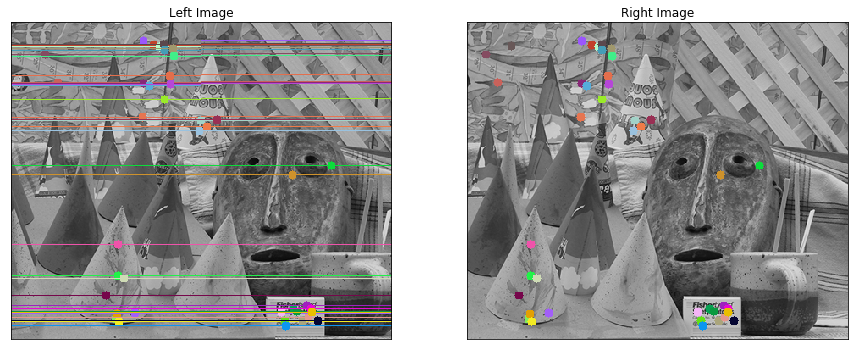

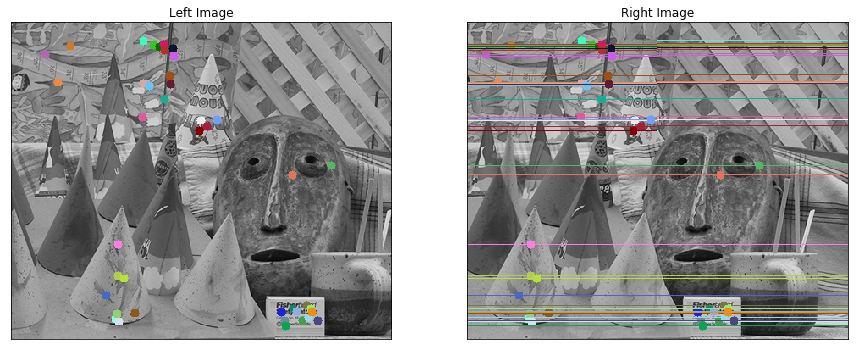

In [3]:
leftIm = cv2.imread("im2.png", cv2.IMREAD_GRAYSCALE)
rightIm = cv2.imread("im6.png", cv2.IMREAD_GRAYSCALE)

# create the sift object
sift = cv2.xfeatures2d.SIFT_create()

# create the matching object
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find the keypoints and the descriptors for both of the images
keypointsLeft, descriptorsL = sift.detectAndCompute(leftIm, None)
keypointsRight, descriptorsR = sift.detectAndCompute(rightIm, None)

# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(descriptorsL, descriptorsR, k=2)

# perform the ratio test to ensure that matches are good - used very low one here to have only a few points (easier to visualize)
goodMatches = []
leftPoints = []
rightPoints = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.11 * n.distance:
        goodMatches.append(m)
        rightPoints.append(keypointsRight[m.trainIdx].pt)
        leftPoints.append(keypointsLeft[m.queryIdx].pt)

# find the Fundamental Matrix
leftPoints = np.int32(leftPoints)
rightPoints = np.int32(rightPoints)
F, mask = cv2.findFundamentalMat(leftPoints, rightPoints, cv2.FM_LMEDS)

# Use only inliers for remaining computations
leftPoints = leftPoints[mask.ravel()==1]
rightPoints = rightPoints[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
leftLines = cv2.computeCorrespondEpilines(rightPoints, 2, F)
leftLines = leftLines.reshape(-1, 3)
# draw lines
leftIm1, rightIm1 = drawlines(leftIm, rightIm, leftLines, leftPoints, rightPoints)

rightLines = cv2.computeCorrespondEpilines(leftPoints, 1, F)
rightLines = rightLines.reshape(-1, 3)
# draw lines
rightIm2, leftIm2 = drawlines(rightIm, leftIm, rightLines, rightPoints, leftPoints)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(leftIm1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(rightIm1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(leftIm2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(rightIm2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

231


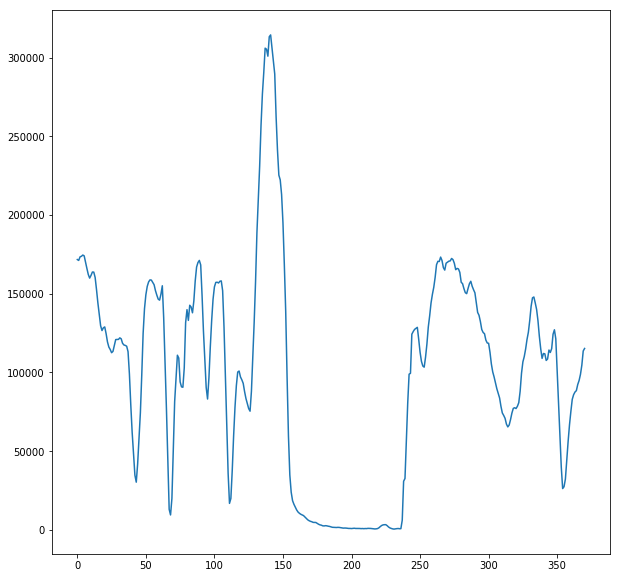

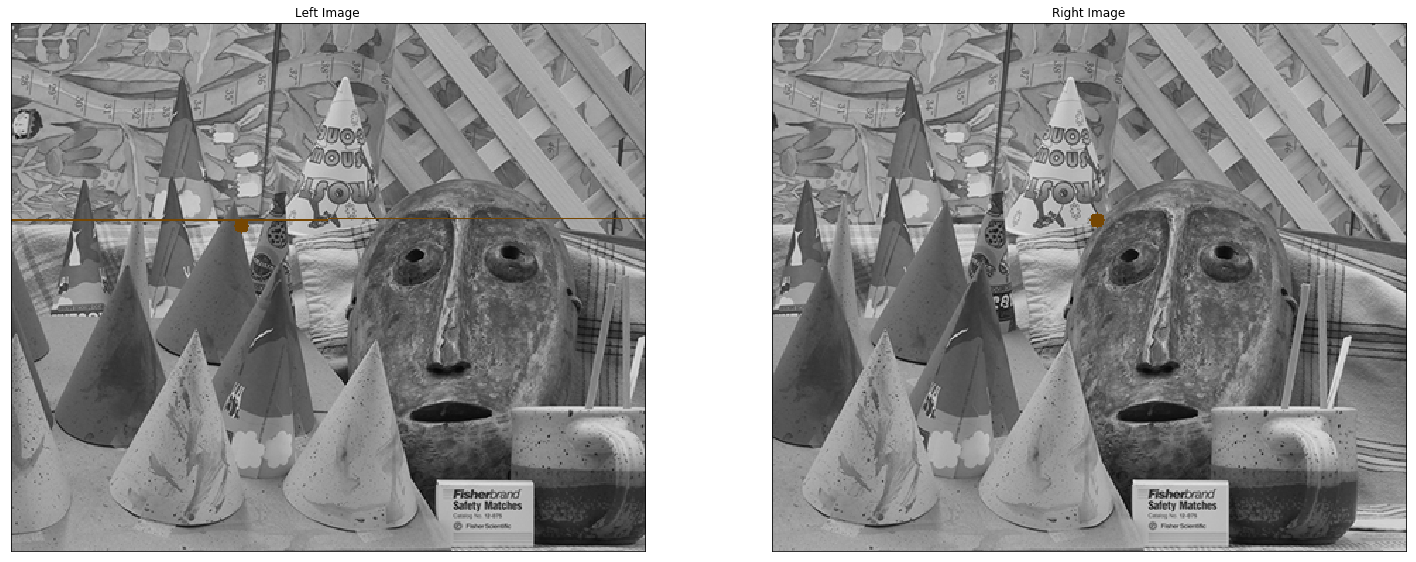

In [4]:
# create the sift object
sift = cv2.xfeatures2d.SIFT_create()

# create the matching object
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find the keypoints and the descriptors for both of the images
keypointsLeft, descriptorsL = sift.detectAndCompute(leftIm, None)
keypointsRight, descriptorsR = sift.detectAndCompute(rightIm, None)

# match descriptors (find the best two matches for each descriptor)
matches = bfMatcher.knnMatch(descriptorsL, descriptorsR, k=2)

# get all of the points so we have a lot of options to find an incorrect one
goodMatches = []
leftPoints = []
rightPoints = []
for i, (m, n) in enumerate(matches):
    if m.distance < n.distance:
        goodMatches.append(m)
        rightPoints.append(keypointsRight[m.trainIdx].pt)
        leftPoints.append(keypointsLeft[m.queryIdx].pt)

# find the Fundamental Matrix
leftPoints = np.int32(leftPoints)
rightPoints = np.int32(rightPoints)
F, mask = cv2.findFundamentalMat(leftPoints, rightPoints, cv2.FM_LMEDS)

# Use only inliers for remaining computations
leftPoints = leftPoints[mask.ravel()==1]
rightPoints = rightPoints[mask.ravel()==1]

# find epilines
# Epilines corresponding to points in the first image is drawn on the
# second image
leftLines = cv2.computeCorrespondEpilines(rightPoints, 2, F)
leftLines = leftLines.reshape(-1, 3)
# draw lines
leftIm1, rightIm1 = drawlines(leftIm, rightIm, leftLines, leftPoints, rightPoints)

rightLines = cv2.computeCorrespondEpilines(leftPoints, 1, F)
rightLines = rightLines.reshape(-1, 3)

# draw the incorrect line (found through trial and error)
leftIm1, rightIm1 = drawlines(leftIm, rightIm, leftLines[166:167], leftPoints[166:167], rightPoints[166:167])

#get the right and the left locations of the point
leftWrongPoint = leftPoints[166:167]
rightWrongPoint = rightPoints[166:167]

#create a blank list for size (5x5)
extracted = np.zeros((5,5))

#save into the list a 5x5 block of the right image centered around the right point
extracted = rightIm[230 - 2 : 230 + 3, 140 - 2 : 140 + 3]

#perform template matching on the whole image
res = cv2.matchTemplate(leftIm, extracted, cv2.TM_SQDIFF)

#create an array to hold the template matched values from the line
line = np.zeros((res.shape[0]))
holder = np.zeros((res.shape[0]))

#find the absolute minimum point while also creating the plot
minimum = 10000
minimumLoc = 0

#take only the values on the line from the above created template matching
#also check if at any point the minimum value is equal to another value on the line
for i in range(0,res.shape[0]):
    line[i] = res[i][140]
    if line[i] < minimum:
        minimum = line[i]
        minimumLoc = i
    elif line[i] == minimum:
        print(i)
    holder[i] = i
    
#plot the values as they occured on the line
print(minimumLoc)
plt.figure(figsize=(10,10))
plt.plot(holder, line)
plt.show()

# display images
plt.figure(figsize=(25,25))
plt.subplot(121), plt.imshow(leftIm1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(rightIm1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

Exactly one match was found where the SSD between the image and the cutout of the right image was found. This point was found to be at x = 231 on the left image. The reason for this is this is - to my knowledge - the correct matching keypoint on the left image for the point on the right image. Though there is a range where the SSD value is low, there is a single absolute minimum as that is the single point that is closest in value to the matched point on the other image.

Theoretically, if multiple matches were found between the image and the cutout, one could use a larger cutout (say 10x10) and compare each of the points which were found to have the smallest difference. This would likely cause the resulting ssd to not be equal for multiple points.

In the case that an incorrect match was found one could use a different method of finding a match. As found in the template matching documentation, one could use something like TM_CCOEFF which instead of finding the minimum distance between the to images it will find the maximum similarity. This will often have the effect of returning a more correct answer when other a specific method is unsuccessful.
